In [6]:
import os
import warnings
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import deepxde as dde

In [7]:
def solve_ADR(xmin, xmax, tmin, tmax, k, v, g, dg, f, u0, Nx, Nt):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x, t)
    with zero boundary condition.
    """
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h**2

    D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)
    D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
    D3 = np.eye(Nx - 2)
    k = k(x)
    M = -np.diag(D1 @ k) @ D1 - 4 * np.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v = v(x)
    v_bond = 2 * h * np.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * np.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond
    f = f(x[:, None], t)

    u = np.zeros((Nx, Nt))
    u[:, 0] = u0(x)
    for i in range(Nt - 1):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = np.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1, i] + 0.5 * f[1:-1, i + 1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        u[1:-1, i + 1] = np.linalg.solve(A, b1 + b2)
    return x, t, u


def main():
    xmin, xmax = -1, 1
    tmin, tmax = 0, 1
    k = lambda x: x**2 - x**2 + 1
    v = lambda x: np.ones_like(x)
    g = lambda u: u**3
    dg = lambda u: 3 * u**2
    f = (
        lambda x, t: np.exp(-t) * (1 + x**2 - 2 * x)
        - (np.exp(-t) * (1 - x**2)) ** 3
    )
    u0 = lambda x: (x + 1) * (1 - x)
    u_true = lambda x, t: np.exp(-t) * (1 - x**2)

    # xmin, xmax = 0, 1
    # tmin, tmax = 0, 1
    # k = lambda x: np.ones_like(x)
    # v = lambda x: np.zeros_like(x)
    # g = lambda u: u ** 2
    # dg = lambda u: 2 * u
    # f = lambda x, t: x * (1 - x) + 2 * t - t ** 2 * (x - x ** 2) ** 2
    # u0 = lambda x: np.zeros_like(x)
    # u_true = lambda x, t: t * x * (1 - x)

    Nx, Nt = 100, 100
    x, t, u = solve_ADR(xmin, xmax, tmin, tmax, k, v, g, dg, f, u0, Nx, Nt)

    print(np.max(abs(u - u_true(x[:, None], t))))
    plt.plot(x, u)
    plt.show()

Compiling model...
Building DeepONetCartesianProd...
'build' took 0.232902 s

'compile' took 118.520389 s



2024-12-04 19:59:59.146069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.66e+00, 2.19e-01, 4.30e-02]    [1.58e+00, 2.32e-01, 4.87e-02]    []  
1000      [1.07e-01, 5.21e-02, 1.50e-02]    [9.26e-02, 4.68e-02, 1.34e-02]    []  
2000      [6.62e-02, 4.01e-02, 9.40e-03]    [5.90e-02, 3.92e-02, 9.69e-03]    []  
3000      [2.77e-02, 2.78e-02, 6.41e-03]    [2.78e-02, 2.50e-02, 5.99e-03]    []  
4000      [1.84e-02, 1.38e-02, 2.53e-03]    [1.79e-02, 1.23e-02, 2.78e-03]    []  
5000      [1.03e-02, 4.24e-03, 3.36e-03]    [1.32e-02, 5.34e-03, 3.81e-03]    []  
6000      [6.09e-03, 1.41e-03, 1.13e-03]    [7.50e-03, 1.89e-03, 1.26e-03]    []  

Best model at step 6000:
  train loss: 8.62e-03
  test loss: 1.06e-02
  test metric: []

'train' took 1681.845513 s

0.05831409410155882


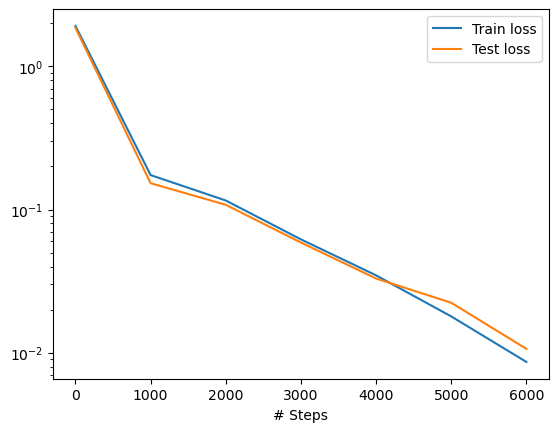

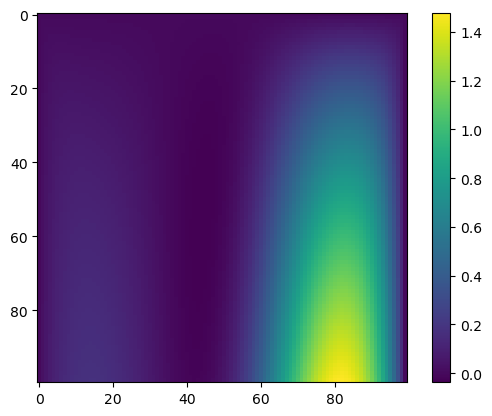

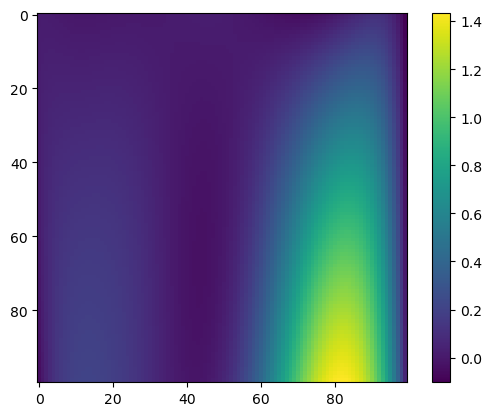

In [9]:
# PDE
def pde_func(x, y, v):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return dy_t - D * dy_xx + k * y**2 - v


geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(
    geomtime, lambda x: np.sin(np.pi * x[:, 0]) * np.exp(-x[:, 1]), lambda _, on_boundary: on_boundary
)
ic = dde.icbc.IC(geomtime, lambda _: 0, lambda _, on_initial: on_initial)

pde = dde.data.TimePDE(
    geomtime,
    pde_func,
    [bc, ic],
    num_domain=200,
    num_boundary=40,
    num_initial=20,
    num_test=500,
)


# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
eval_pts = np.linspace(0, 1, num=50)[:, None]
data = dde.data.PDEOperatorCartesianProd(
    pde,
    func_space,
    eval_pts,
    1000,
    function_variables=[0],
    num_test=100,
    batch_size=50,
)

# Net
net = dde.nn.DeepONetCartesianProd(
    [50, 128, 128, 128],
    [2, 128, 128, 128],
    "tanh",
    "Glorot normal",
)

model = dde.Model(data, net)
model.compile("adam", lr=0.0005)


losshistory, train_state = model.train(iterations=6000)
dde.utils.plot_loss_history(losshistory)

func_feats = func_space.random(1)
xs = np.linspace(0, 1, num=100)[:, None]
v = func_space.eval_batch(func_feats, xs)[0]
x, t, u_true = solve_ADR(
    0,
    1,
    0,
    1,
    lambda x: 0.01 * np.ones_like(x),
    lambda x: np.zeros_like(x),
    lambda u: 0.01 * u**2,
    lambda u: 0.02 * u,
    lambda x, t: np.tile(v[:, None], (1, len(t))),
    lambda x: np.zeros_like(x),
    100,
    100,
)
u_true = u_true.T
plt.figure()
plt.imshow(u_true)
plt.colorbar()

v_branch = func_space.eval_batch(func_feats, np.linspace(0, 1, num=50)[:, None])
xv, tv = np.meshgrid(x, t)
x_trunk = np.vstack((np.ravel(xv), np.ravel(tv))).T
u_pred = model.predict((v_branch, x_trunk))
u_pred = u_pred.reshape((100, 100))
print(dde.metrics.l2_relative_error(u_true, u_pred))
plt.figure()
plt.imshow(u_pred)
plt.colorbar()
plt.show()